In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  


sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

# Анализ пользователей с refund (съехали даты завершения подписок)

In [4]:
query = f''' SELECT t1.*,t2.offer_duration AS offer_duration
             FROM datamarts.finance AS t1
             LEFT JOIN datamarts.marketing_dash AS t2 ON t1.user_id=t2.user_id
             WHERE paid_date>='2024-01-01'
             '''

df_payment = execute(query,user='kmekhtiev')
df_payment['paid_date'] = pd.to_datetime(df_payment['paid_date'])

# Список тех, кому вернули деньги 
df_refund = pd.read_csv('/Users/kemran/Downloads/fix_ent_at_after_refund.csv')
df_refund['true_end_at'] = pd.to_datetime(df_refund['true_end_at']).dt.date

# Для тех, кто триальщик и нет в таблице datamarts.finance,  чтобы узнать дату оформления триала и дату списания
query= f'''SELECT * FROM datamarts.marketing_dash'''
df_marketing = execute(query,user='kmekhtiev')
df_marketing['first_prolong_date'] = pd.to_datetime(df_marketing['first_prolong_date']).dt.date
df_marketing['created_at'] = pd.to_datetime(df_marketing['created_at']).dt.date

Время выполнения функции: 16.143 секунд

Время выполнения функции: 532.0699 секунд



In [64]:
query = f''' SELECT t1.*,t2.offer_duration AS offer_duration,t2.ends_at AS ends_at
             FROM datamarts.finance AS t1
             LEFT JOIN datamarts.marketing_dash AS t2 ON t1.user_id=t2.user_id
             WHERE paid_date>='2024-01-01'
             '''

df_payment = execute(query,user='kmekhtiev')
df_payment['paid_date'] = pd.to_datetime(df_payment['paid_date'])

Время выполнения функции: 26.3072 секунд



In [66]:
df_refund.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6256 entries, 0 to 6255
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                6256 non-null   object
 1   end_at                 6256 non-null   object
 2   true_end_at            6256 non-null   object
 3   use_end_at_from_bonus  6251 non-null   object
 4   dobil                  6256 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 201.7+ KB


In [68]:
df_marketing[['first_prolong_date','created_at']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851887 entries, 0 to 851886
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   first_prolong_date  851887 non-null  object
 1   created_at          851887 non-null  object
dtypes: object(2)
memory usage: 13.0+ MB


In [70]:
# Списаний еще ни у кого не было, у кого был refund
pd.merge(df_payment[(df_payment['paid_date']>='2025-06-07')],df_refund,how='inner',on = 'user_id')

,paid_date,subscription_id,user_id,platform,price_currency,free_days,bonus_title,reg_device,reg_date,reg_source,reg_medium,reg_campaign,b2b_b2c,payment,offer_duration,ends_at,end_at,true_end_at,use_end_at_from_bonus,dobil


In [72]:
df_payment['last_payment'] = df_payment.groupby('user_id')['paid_date'].transform('max')


df_refund_merge = pd.merge(df_refund,df_payment[df_payment['last_payment'] == df_payment['paid_date']][['user_id','payment','last_payment','offer_duration']],how='left',on='user_id')

In [74]:
# Здесь мы мерджим таблицу для добавления даннных по триальщикам
df_refund_marketing_merge = pd.merge(df_refund_merge,df_marketing[['user_id','created_at','first_prolong_date','free_days','price_cents']],how='left',on='user_id')
df_refund_marketing_merge['type'] = df_refund_marketing_merge['offer_duration'].apply(lambda x:'trial' if pd.isna(x) else 'subs')

# Оставляем месяца из оффера
df_refund_marketing_merge['offer_month'] = df_refund_marketing_merge['offer_duration'].str.split().str[0]

In [76]:
df_refund_marketing_merge = df_refund_marketing_merge[df_refund_marketing_merge['free_days'].notna()]
df_refund_marketing_merge['last_payment'] = pd.to_datetime(df_refund_marketing_merge['last_payment'])
df_refund_marketing_merge['created_at'] = pd.to_datetime(df_refund_marketing_merge['created_at'])

df_refund_marketing_merge['offer_month'] = df_refund_marketing_merge['offer_month'].fillna(0)
df_refund_marketing_merge['offer_month'] = df_refund_marketing_merge['offer_month'].astype('int')
df_refund_marketing_merge['free_days'] = df_refund_marketing_merge['free_days'].astype('int')


# Создаем новую колонку с датой + offer_month месяцев
df_refund_marketing_merge['new_date'] = df_refund_marketing_merge.apply(
    lambda x: x['last_payment'] + pd.DateOffset(months=x['offer_month']) if x['type']=='subs' 
    else x['created_at'] + pd.Timedelta(days=x['free_days']),
    axis=1
    )

# У триальщиков вместо nan пропишем их цену, которую они должны были заплатить
df_refund_marketing_merge['payment'] = df_refund_marketing_merge.apply(
    lambda x: x['price_cents']/100 if x['type']=='trial' 
    else x['payment'],
    axis=1
    )

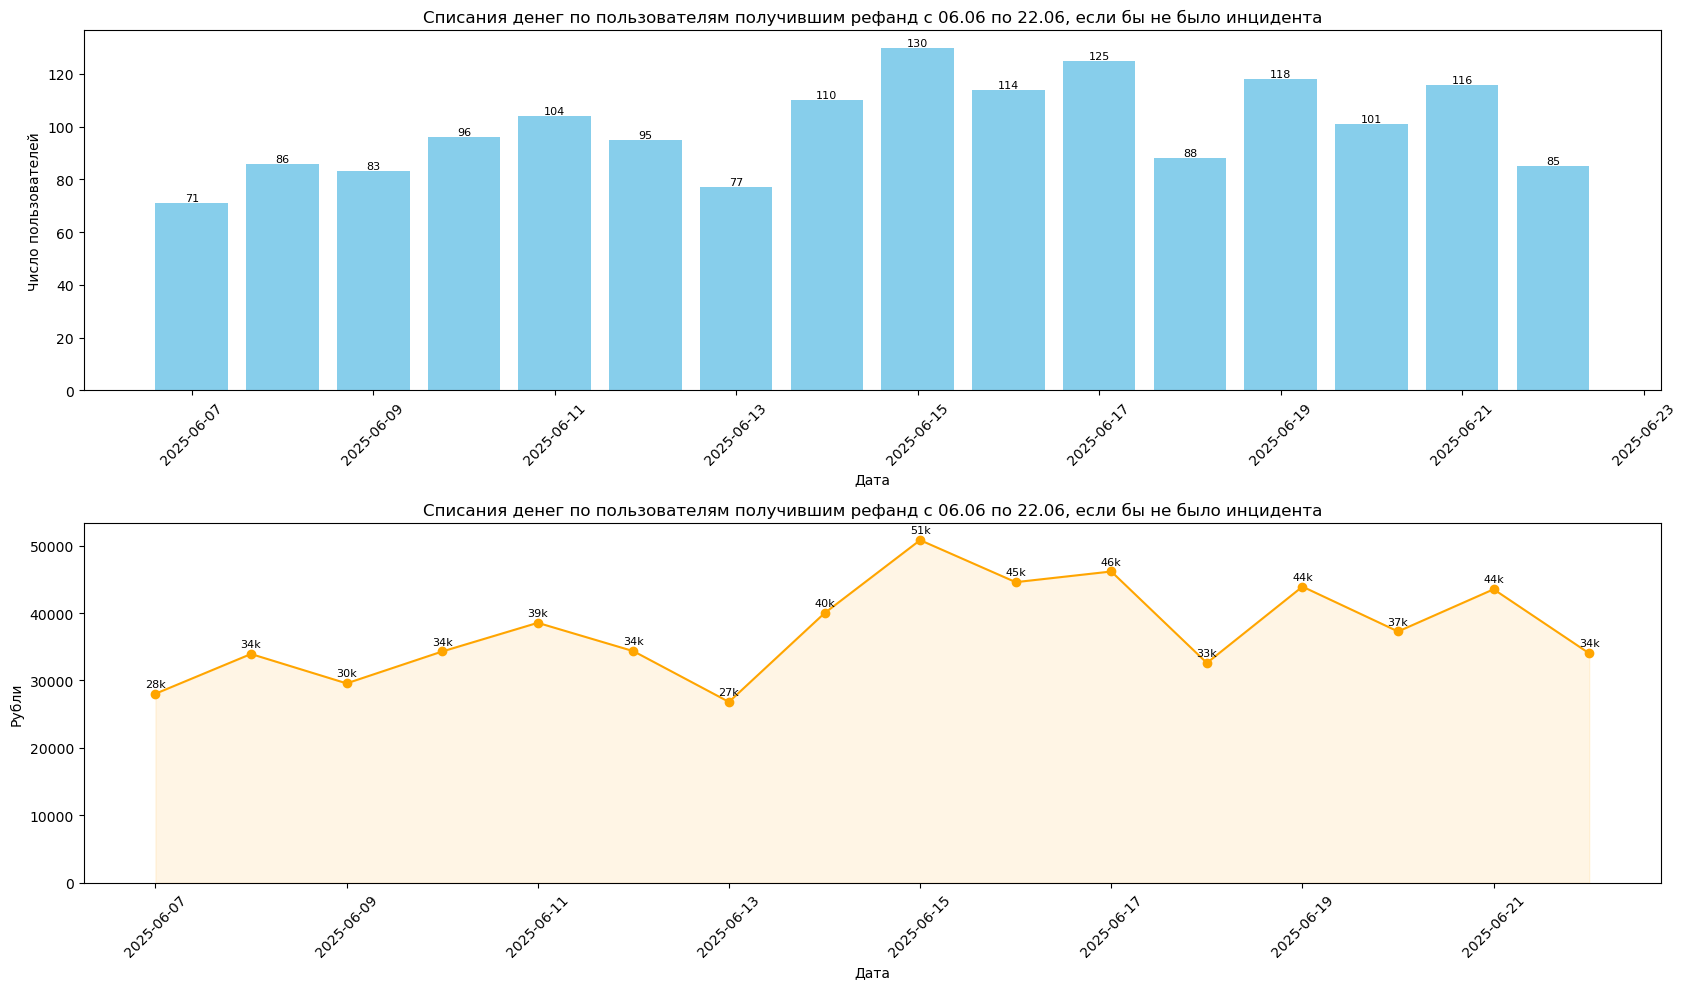

In [78]:
df_refund_marketing_merge_agg = df_refund_marketing_merge.groupby('new_date',as_index=False).agg({'payment':'sum','user_id':'nunique'})

data = df_refund_marketing_merge_agg[(df_refund_marketing_merge_agg['new_date']>='2025-06-07') & (df_refund_marketing_merge_agg['new_date']<'2025-06-23')]
data.rename(columns={'payment':'payment_refund_user','user_id':'cnt_refund_user'},inplace=True)
data['payment_refund_user'] = data['payment_refund_user'].astype('int')
# Для форматирования вывода чисел в формат nk, где n - рубли 
def format_k(value):
    if value >= 1000:
        return f"{round(value/1000)}k"
    else:
        return str(value)
    
fig,axs = plt.subplots(2,1,figsize = (17,10),dpi=100)

bars = axs[0].bar(data['new_date'], data['cnt_refund_user'],color='skyblue')
axs[0].tick_params(axis='x', rotation=45)

axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Число пользователей')
axs[0].set_title ('Списания денег по пользователям получившим рефанд с 06.06 по 22.06, если бы не было инцидента') 

for bar in bars:
    height = bar.get_height()
    axs[0].text(
        bar.get_x() + bar.get_width() / 2,  
        height,                            
        f'{int(height)}',                   
        ha='center', va='bottom', fontsize=8
    )

axs[1].plot(data['new_date'],data['payment_refund_user'], marker='o',color='orange')
axs[1].tick_params(axis='x', rotation=45)


axs[1].fill_between(
    data['new_date'], 
    data['payment_refund_user'], 
    color='orange', alpha=0.1
)

for index, row in data.iterrows():
    axs[1].annotate(
        format_k(row['payment_refund_user']),
        (row['new_date'], row['payment_refund_user']),
        textcoords="offset points",
        xytext=(0,5),
        ha='center',
        fontsize=8
    )

axs[1].set_xlabel('Дата')
axs[1].set_ylabel('Рубли')
axs[1].set_title ('Списания денег по пользователям получившим рефанд с 06.06 по 22.06, если бы не было инцидента') 
axs[1].set_ylim(0)


plt.tight_layout()
plt.show()

In [80]:
data['payment_refund_user'].sum()

598388

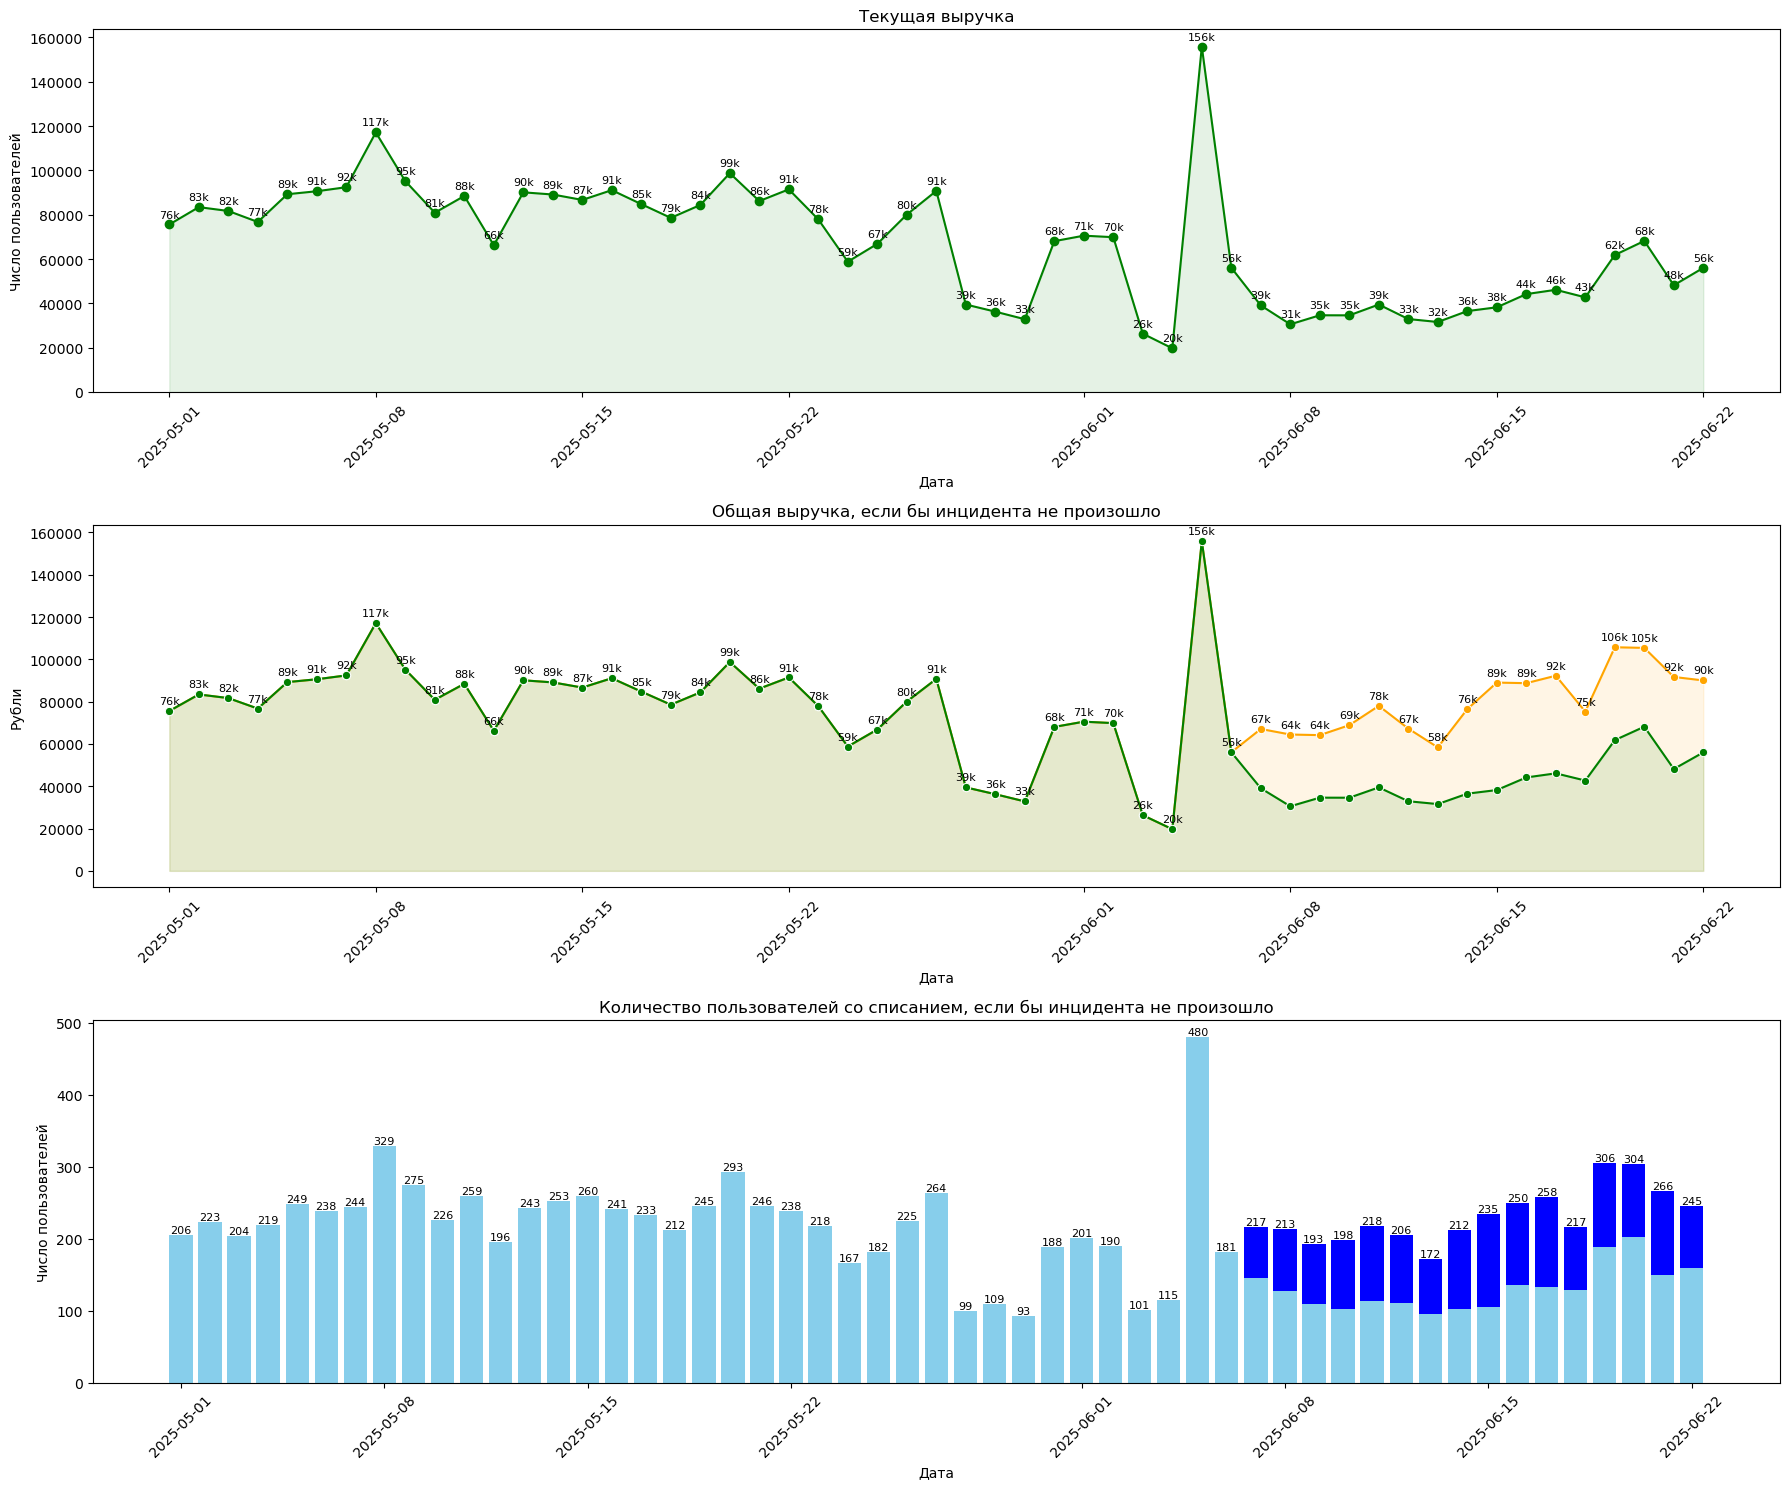

In [82]:

df_payment_agg = df_payment[(df_payment['paid_date']>='2025-05-01') & (df_payment['paid_date']<'2025-06-23')]\
                .groupby('paid_date',as_index=False)\
                .agg({'payment':'sum','user_id':'nunique'})

df_payment_agg_merge = pd.merge(df_payment_agg,data,left_on='paid_date',right_on='new_date',how='left').fillna(0)
df_payment_agg_merge['total_payment'] = df_payment_agg_merge['payment'] + df_payment_agg_merge['payment_refund_user']
df_payment_agg_merge['total_user'] = df_payment_agg_merge['user_id'] + df_payment_agg_merge['cnt_refund_user']

fig, axs = plt.subplots(3, 1, figsize=(18,15), dpi=100)

axs[0].plot(df_payment_agg['paid_date'], df_payment_agg['payment'], marker='o', color='green')

# Заполняем область под линией
axs[0].fill_between(
    df_payment_agg['paid_date'], 
    df_payment_agg['payment'], 
    color='green', alpha=0.1
)

axs[0].tick_params(axis='x', rotation=45)

for index, row in df_payment_agg.iterrows():
    axs[0].annotate(
        format_k(row['payment']),
        (row['paid_date'], row['payment']),
        textcoords="offset points",
        xytext=(0,5),
        ha='center',
        fontsize=8
    )

axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Число пользователей')
axs[0].set_title('Текущая выручка') 
axs[0].set_ylim(0)


# Второй график
sns.lineplot(data=df_payment_agg_merge, y='total_payment', x='paid_date', color='orange', marker='o', ax=axs[1])
sns.lineplot(data=df_payment_agg_merge, y='payment', x='paid_date', color='green', marker='o', ax=axs[1])

axs[1].fill_between(
    df_payment_agg_merge['paid_date'], 
    df_payment_agg_merge['total_payment'], 
    color='orange', alpha=0.1)

axs[1].fill_between(
    df_payment_agg_merge['paid_date'], 
    df_payment_agg_merge['payment'], 
    color='green', alpha=0.1)

for index, row in df_payment_agg_merge.iterrows():
    axs[1].annotate(
        format_k(row['total_payment']),
        (row['paid_date'], row['total_payment']),
        textcoords="offset points",
        xytext=(0,5),
        ha='center',
        fontsize=8
    )

axs[1].tick_params(axis='x', rotation=45)

axs[1].set_xlabel('Дата')
axs[1].set_ylabel('Рубли')
axs[1].set_title('Общая выручка, если бы инцидента не произошло')




# Третий график
bar1 = axs[2].bar(df_payment_agg_merge['paid_date'], df_payment_agg_merge['total_user'],color='blue')
bar2 = axs[2].bar(df_payment_agg_merge['paid_date'], df_payment_agg_merge['user_id'],color='skyblue')



for bar in bar1:
    height = bar.get_height()
    axs[2].text(
        bar.get_x() + bar.get_width() / 2,  
        height,                            
        f'{int(height)}',                   
        ha='center', va='bottom', fontsize=8
    )

axs[2].tick_params(axis='x', rotation=45)

axs[2].set_xlabel('Дата')
axs[2].set_ylabel('Число пользователей')
axs[2].set_title('Количество пользователей со списанием, если бы инцидента не произошло')

plt.tight_layout()
plt.show()

# Добиливание пользователей 19.06 пользователей с <6 


In [85]:
df_dobill = pd.read_csv('/Users/kemran/Downloads/dobill_17.06.csv')

In [87]:
# Кого удалось добилить
df_dobill_real = pd.merge(df_dobill,df_payment[df_payment['paid_date']=='2025-06-20'],how='inner',on='user_id')

In [89]:
df_dobill_real['user_id'].nunique()

8

In [91]:
df_dobill_real['payment'].sum()

2922

In [93]:
df_dobill['user_id'].nunique()

513

# Пользователи Сбера,Google play и App store

In [96]:
df_google = pd.read_csv('/Users/kemran/Downloads/googleplay.csv')
df_appstore = pd.read_csv('/Users/kemran/Downloads/appstore.csv')

df_stores = pd.concat([df_google,df_appstore],ignore_index=True)

In [98]:
df_stores_merge = pd.merge(df_stores,df_payment[df_payment['last_payment'] == df_payment['paid_date']][['user_id','payment','last_payment','offer_duration']],how='left',on='user_id')


df_stores_marketing = pd.merge(df_stores_merge,df_marketing[['user_id','created_at','first_prolong_date','free_days','price_cents']],how='left',on='user_id')

In [99]:
df_stores_marketing_agg = df_stores_marketing.groupby('store').agg({'price_cents':'sum','user_id':'nunique'}).reset_index()
df_stores_marketing_agg.iloc[0,1] = df_stores_marketing_agg.iloc[0,1]/100


In [102]:
df_stores_marketing_agg

,store,price_cents,user_id
0,appstore,1596,4
1,googleplay,1495,5


# Отметим на графике все основные факторы повлиявшие на выручку

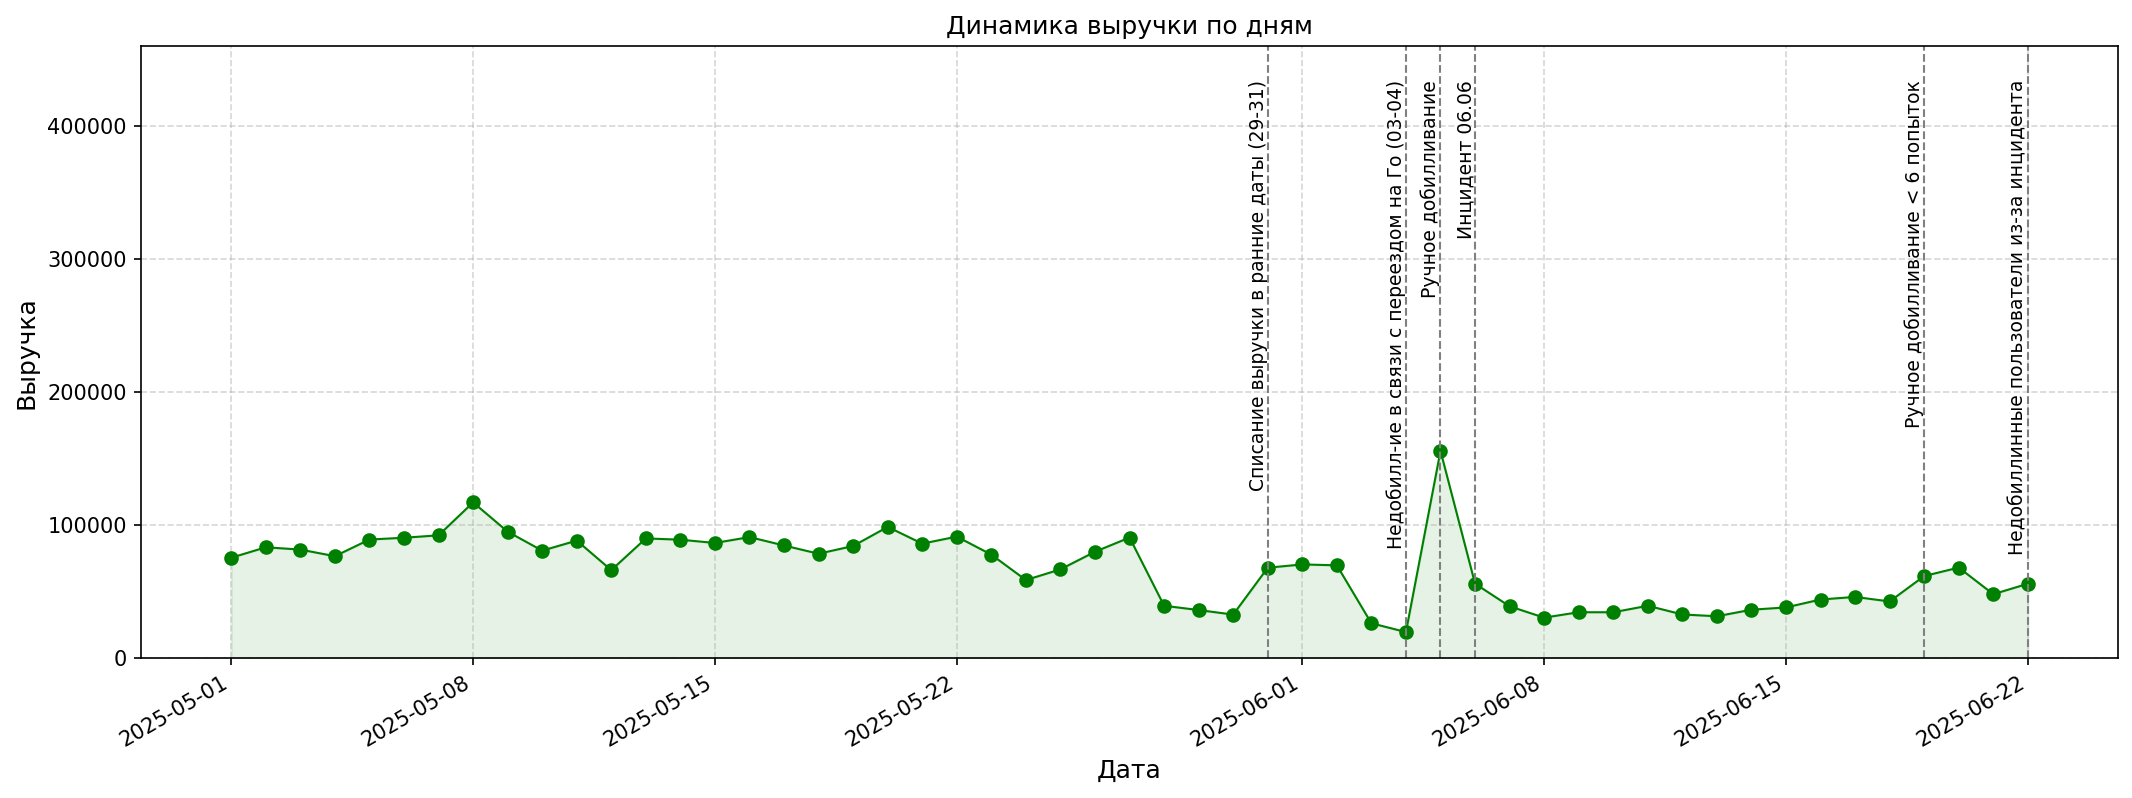

In [105]:
# События, которые нужно отобразить
events = {
    'Списание выручки в ранние даты (29-31)': '2025-05-31',
    'Недобилл-ие в связи с переездом на Го (03-04)': '2025-06-04',
    'Ручное добилливание': '2025-06-05',
    'Инцидент 06.06':'2025-06-06',
    'Ручное добилливание < 6 попыток': '2025-06-19',
    'Недобиллинные пользователи из-за инцидента': '2025-06-22',

}

df_payment_agg = df_payment[(df_payment['paid_date']>='2025-05-01') & (df_payment['paid_date']<'2025-06-23')].groupby('paid_date')['payment'].sum().reset_index()
fig, ax = plt.subplots(figsize=(17, 6),dpi = 150)

# Линия + точки
ax.plot(df_payment_agg['paid_date'], df_payment_agg['payment'], marker='o', color='green', linewidth=1)

for label, date_str in events.items():
    date = pd.to_datetime(date_str)
    ax.axvline(date, color='gray', linestyle='--', linewidth=1)
    ax.text(date, df_payment_agg['payment'].max() * 2.79, label, rotation=90,
            verticalalignment='top', fontsize=9, color='black', ha='right')
    
ax.fill_between(
    df_payment_agg['paid_date'], 
    df_payment_agg['payment'], 
    color='green', alpha=0.1)

ax.set_title('Динамика выручки по дням', fontsize=12)
ax.set_xlabel('Дата', fontsize=12)
ax.set_ylabel('Выручка', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_ylim(bottom=0,top=460000)
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
fig.autofmt_xdate()

# Пользователи, у которых мы украли подписку

In [110]:
df_payment[(df_payment['last_payment'] == df_payment['paid_date']) & (df_payment['user_id']=='f0c493e0-da29-4297-a3fd-adbfa9ee3eb0')]

,paid_date,subscription_id,user_id,platform,price_currency,free_days,bonus_title,reg_device,reg_date,reg_source,reg_medium,reg_campaign,b2b_b2c,payment,offer_duration,ends_at,last_payment
72751,2025-06-06,deef6990-c13a-472f-b01f-8e5c77672324,f0c493e0-da29-4297-a3fd-adbfa9ee3eb0,cloudpayments,RUB,35,Flocktory: Exchange 365 (3&399) ver 2 (act),web_mobile,2025-01-17,flocktory,exchange,919510,b2c,399,3 month,2025-06-07,2025-06-06


In [144]:
df_payment['offer_month'] = df_payment['offer_duration'].str.split().str[0]
df_payment['offer_month'] = df_payment['offer_month'].fillna(0)
df_payment['offer_month'] = df_payment['offer_month'].astype('int')
df_payment['ends_at'] = df_payment['ends_at'].astype('datetime64[ns]')


df_payment['real_end_date'] = df_payment.apply(
                                                lambda x: x['last_payment'] + pd.DateOffset(months=x['offer_month']),
                                                axis=1
                                                )

In [216]:
df_payment_filter = df_payment[(df_payment['last_payment'] == df_payment['paid_date'])]
df_payment_filter_merge = pd.merge(df_payment_filter,df_marketing[['user_id','state']],how='left',on='user_id')
t = df_payment_filter_merge[(df_payment_filter_merge['offer_month']!=0) & (df_payment_filter_merge['ends_at']=='2025-06-07') & (df_payment_filter_merge['real_end_date']!=df_payment_filter_merge['ends_at'])]

y = t[['user_id','ends_at','real_end_date','offer_month','paid_date','offer_month']]
y.rename(columns={'paid_date':'last_payment_date'},inplace=True)
#t[t['user_id']=='f0c493e0-da29-4297-a3fd-adbfa9ee3eb0']

t['platform'].value_counts()

platform
cloudpayments    123
payture            8
Name: count, dtype: int64

In [200]:
y.to_csv('Users_with_incorrect_ends_period.csv',sep=',')

In [232]:
t['state'].value_counts()

state
canceled        95
grace_period    36
Name: count, dtype: int64